In [ ]:
!pip install qiskit
!pip install qiskit-aer-gpu

In [2]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

df = pd.read_csv("/content/sample_data/mnist_train_small.csv", header=None)
df = df.loc[(df.iloc[:, 0] == 0) + (df.iloc[:, 0] == 1)]

In [3]:
image_size = 16

In [4]:
#data preprocessing
#make (28x28) -> (16x16)

def reduce(arr):
  temp =  np.array(arr).reshape(28, 28).tolist()
  temp.insert(0, [0]*28)
  temp.insert(0, [0]*28)
  temp.insert(-1, [0]*28)
  temp.insert(-1, [0]*28)
  for i in range(len(temp)):
    temp[i].insert(0, 0)
    temp[i].insert(0, 0)
    temp[i].insert(-1, 0)
    temp[i].insert(-1, 0)

  temp2 = []
  for i in range(int(len(temp)/2)):
    t = []
    for j in range(int(len(temp)/2)):  
      tt = (temp[2*i][2*j] + temp[2*i+1][2*j]
            + temp[2*i][2*j+1] + temp[2*i+1][2*j+1])/4
      t.append(int(tt))
    temp2.append(t)

  return temp2

col_name2=["label"]
for i in range(image_size*image_size):
  col_name2.append("pixel"+str(i))

dfToList = df.values

save = []
for digit in dfToList:
  t = [digit[0]]
  t += np.array(reduce(digit[1:])).reshape(256).tolist()
  save.append(t)

save_test=pd.DataFrame(save, columns=col_name2)[:100]
save_train=pd.DataFrame(save, columns=col_name2)[100:]

save_train.to_csv("./mnist_zero_minisize_full_train.csv", index=False)
save_test.to_csv("./mnist_zero_minisize_full_test.csv", index=False)

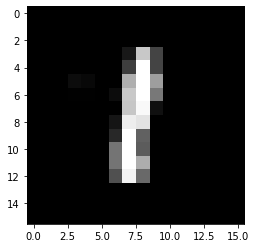

In [5]:
df2 = pd.read_csv("./mnist_zero_minisize_full_train.csv")

plt.imshow(np.array(df2.iloc[0, 1:]).reshape(16, 16), cmap='gray', interpolation='none')

image = df2.iloc[0, 1:] / 256

image = np.array(image)
image = image.astype(np.float32).reshape(16, 16)

In [6]:
class DigitsDataset(Dataset):
    """Pytorch dataloader for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, csv_file, label=0, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            label (int): labels for each feater data
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_file = csv_file
        self.transform = transform
        self.df = pd.read_csv(self.csv_file)

    # def filter_by_label(self, label):
    #     df = pd.read_csv(self.csv_file)
    #     df = df.loc[df.iloc[:, -1] == label]
    #     return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.df.iloc[idx, 1:] / 256
        image = np.array(image)
        image = image.astype(np.float32).reshape(16, 16)

        if self.transform:
            image = self.transform(image)

        # Return image and label
        return image, self.df.iloc[idx, 0]

batch_size = 1

transform = transforms.Compose([transforms.ToTensor()])
dataset = DigitsDataset(csv_file="./mnist_zero_minisize_full_train.csv", transform=transform)
dataset_test = DigitsDataset(csv_file="./mnist_zero_minisize_full_test.csv", transform=transform)

dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)
dataloader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=True, drop_last=True
)

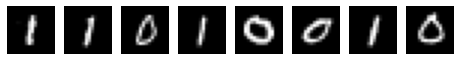

In [7]:
plt.figure(figsize=(8,2))

for i in range(8):
    image = dataset[i][0].reshape(image_size,image_size)
    plt.subplot(1,8,i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')

plt.show()

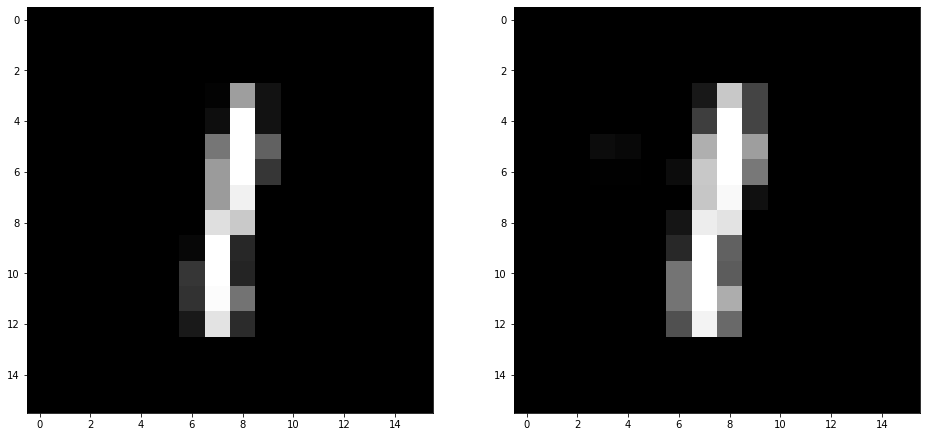

In [8]:
#amplitude encoding
#just use qiskit module 'initialize'

from qiskit import QuantumCircuit, execute, BasicAer
from sklearn.preprocessing import normalize

test = dataset[0][0].reshape(1, -1) 
test = normalize(test)[0] 


circuit = QuantumCircuit(8, 8)
circuit.initialize(test, circuit.qubits)
circuit.measure([0, 1, 2, 3, 4,5, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7])
# circuit.draw()

shots = 100000

# Desired vector
desired_vector = test

# Initialize on local simulator
sim_backend = BasicAer.get_backend("qasm_simulator")
job = execute(circuit, sim_backend, shots=shots)
result = job.result()

counts = result.get_counts(circuit)

qubit_strings = [format(i, "0%sb" % 8) for i in range(2**8)]
image = np.array([float(format(counts.get(s, 0) / shots, ".3f")) for s in qubit_strings])
image = image.astype(np.float32).reshape(16, 16)
plt.figure(figsize=(16, 8))
plt.axis('off')
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray', interpolation='none')
plt.subplot(1,2,2)
plt.imshow(dataset[0][0].reshape(16, 16), cmap='gray', interpolation='none')

In [9]:
n_qubits = 8
n_out_qubit = 1
n_conv = 6
n_pool = 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
#model
import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *
from qiskit.circuit import QuantumCircuit, ParameterVector
from torch.autograd import Function


def convolution(n_qubits, params):
    _circuit = qiskit.QuantumCircuit(n_qubits)

    _circuit.ry(params[0], 0)
    _circuit.ry(params[1], 1)
    _circuit.cz(0, 1)
    _circuit.ry(params[2], 0)
    _circuit.ry(params[3], 1)
    _circuit.cz(0, 1)
    _circuit.ry(params[4], 0)
    _circuit.ry(params[5], 1)
    return _circuit


def pooling(n_qubits, params):
    _circuit = qiskit.QuantumCircuit(n_qubits) 

    _circuit.crz(params[0], 0, 1)
    _circuit.x(0)
    _circuit.crx(params[1], 0, 1)
    return _circuit

class QCircuit():
  def __init__(self,n_qubits, n_out_qubit, n_conv, n_pool, backend, shots):
    # raise exception when n_qubits is not power of 2
    self._circuit = qiskit.QuantumCircuit(n_qubits, n_out_qubit)
    tt = 2*n_out_qubit - 3 if n_out_qubit != 1 else 0 
    self.params_conv = ParameterVector("C", n_conv*(2*n_qubits - 3 - tt))
    self.params_pool = ParameterVector("P", n_pool*(n_qubits - 1 - tt))
    self.n_qubits = n_qubits
    self.n_out_qubit = n_out_qubit

    layer = n_qubits
    j = 1
    iter_conv = 0
    iter_pool = 0
    while layer > n_out_qubit:
      for i in range(int(layer/2)):
        self._circuit.compose(convolution(2, self.params_conv[iter_conv:iter_conv+n_conv]), 
                              qubits=[j*2*i + j-1, j*2*i + j-1 + j*1], inplace=True)
        iter_conv += n_conv

      self._circuit.barrier()
      if(int(layer/2) > 1): 
        for i in range(int(layer/2)):
          self._circuit.compose(convolution(2, self.params_conv[iter_conv:iter_conv+n_conv]), 
                                qubits=[j*2*i + j-1 + j*1, (j*2*i + j-1 + j*2)%(n_qubits)], inplace=True)
          iter_conv += n_conv
        self._circuit.barrier() 

      for i in range(int(layer/2)):
            self._circuit.compose(pooling(2, self.params_pool[iter_pool:iter_pool+n_pool]),
                                  qubits=[j*2*i + j-1, j*2*i + j-1 + j*1], inplace=True)
            iter_pool +=n_pool
      self._circuit.barrier()

      layer = int(layer/2)
      j *= 2
    for i in range(n_out_qubit):
      self._circuit.measure(int(n_qubits/(2**i))-1, i)
    # ---------------------------

    self.backend = backend
    self.shots = shots


  def run(self, input, conv, pool):
    # amplitude encoding
    input_normalized = input.reshape(1, -1).cpu()
    input_normalized = normalize(input_normalized)[0] 
    circuit = QuantumCircuit(self.n_qubits)
    circuit.initialize(input_normalized, circuit.qubits)
    
    # paramter binding
    temp = self._circuit.bind_parameters({self.params_conv: conv.tolist()})
    temp = temp.bind_parameters({self.params_pool: pool.tolist()})
    circuit.compose(temp, qubits=[i for i in range(self.n_qubits)], inplace=True)

    circuit = transpile(circuit, backend=self.backend)
    qobj = assemble(circuit,
                    shots=self.shots)
    job = self.backend.run(qobj)
    result = job.result().get_counts()

    counts = np.array(list(result.values()))
    states = np.array(list(result.keys())).astype(float)
    
    # Compute probabilities for each state
    probabilities = counts / self.shots
    # Get state expectation
    expectation = np.sum(states * probabilities)
    
    return torch.tensor([expectation]).to(device)

###### backpropagation????     
class QFunction(Function):
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift, conv, pool):
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        

        expectation_z = ctx.quantum_circuit.run(input, conv, pool).to(device)
        
        ctx.save_for_backward(input, conv, pool, expectation_z)

        return expectation_z.clone()
        
    @staticmethod
    def backward(ctx, grad_output):
        input, conv, pool, expectation_z = ctx.saved_tensors

        
        conv_shift_right = conv + torch.ones(conv.shape).to(device) * ctx.shift
        conv_shift_left = conv - torch.ones(conv.shape).to(device) * ctx.shift
        pool_shift_right = pool + torch.ones(pool.shape).to(device) * ctx.shift
        pool_shift_left = pool - torch.ones(pool.shape).to(device) * ctx.shift
        
        gradients_conv = []
        gradients_pool=[]

        for i in range(len(conv)):
          right = torch.cat((conv[:i], torch.unsqueeze(conv_shift_right[i], 0), conv[i+1:]), 0)
          left = torch.cat((conv[:i], torch.unsqueeze(conv_shift_left[i], 0), conv[i+1:]), 0)

          expectation_right = ctx.quantum_circuit.run(input, right, pool)
          expectation_left  = ctx.quantum_circuit.run(input, left, pool)
        
          gradient = ((expectation_right.clone().detach()) 
                      - (expectation_left.clone().detach())).mean()*grad_output
          gradients_conv.append(gradient.item())

        for i in range(len(pool)):
          right = torch.cat((pool[:i], torch.unsqueeze(pool_shift_right[i], 0), pool[i+1:]), 0)
          left = torch.cat((pool[:i], torch.unsqueeze(pool_shift_left[i], 0), pool[i+1:]), 0)

          expectation_right = ctx.quantum_circuit.run(input, conv, right)
          expectation_left  = ctx.quantum_circuit.run(input, conv, left)
        
          gradient = ((expectation_right.clone().detach()) 
                      - (expectation_left.clone().detach())).mean()*grad_output
          gradients_pool.append(gradient.item())

        gradients_pool =  torch.tensor(gradients_pool).to(device)
        gradients_conv =  torch.tensor(gradients_conv).to(device)
        return None, None, None, gradients_conv, gradients_pool 


class QCNN(nn.Module):   
    def __init__(self, backend, shots, shift):
        super(QCNN, self).__init__()
        self.quantum_circuit = QCircuit(n_qubits, n_out_qubit, n_conv, n_pool, backend, shots)
        self.shift = shift
        tt = 2*n_out_qubit - 3 if n_out_qubit != 1 else 0
        
        self.conv_params = nn.Parameter(torch.rand(n_conv*(2*n_qubits - 3 - tt)), requires_grad=True)
        self.pool_params = nn.Parameter(torch.rand( n_pool*(n_qubits - 1 - tt)), requires_grad=True)
        
    def forward(self, input):
        return QFunction.apply(input, self.quantum_circuit, self.shift, self.conv_params, self.pool_params)
    
    


In [11]:
lr = 0.01
num_iter = 500

In [12]:
def test(model, dataloader_test):
    total_loss = []
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(dataloader_test):
            output = model(data).cpu()

            pred = output >= 0.5
            correct += pred.eq(target.view_as(pred)).sum().item()

            loss = criterion(output, target.double())
            total_loss.append(loss.item())

        return sum(total_loss) / len(total_loss), (correct / len(dataloader_test) * 100)


def saveList(lst, title, ylabel):
    x = [i for i in range(len(lst))]
    plt.cla()
    plt.plot(x, lst, 'o-')
    plt.title(title)
    plt.ylabel(ylabel)
    fname = title+".png"
    plt.savefig(fname)

In [ ]:
simulator_gpu = qiskit.Aer.get_backend('aer_simulator')
simulator_gpu.set_options(device='GPU')
qcnn = QCNN(simulator_gpu, 100, np.pi/2).to(device)

# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
opt = optim.SGD(qcnn.parameters(), lr=lr)

# Iteration counter
counter = 0
iter_n = 0

# plot things
loss_train = []
loss_test = []
accuracy_test = []

while True:
    for i, (data, label) in enumerate(dataloader):
        # Data for training the discriminator
        # for 1 batch
        data = data.reshape(-1, image_size * image_size)
        data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
               
        # Training the discriminator
        qcnn.zero_grad()
        out = qcnn(data).view(-1).to(device)
        err = criterion(out, label.to(device).double())
        loss_train.append(err.item())
        err.backward()
        
        opt.step()

        
        counter += 1
        
        # Show loss values
        if counter % 10 == 0:
            print(f'Iteration: {counter}, Loss: {err:0.3f}')

        if counter % 100 == 0:
            test_loss, test_accuracy = test(qcnn, dataloader_test)
            loss_test.append(test_loss)
            accuracy_test.append(test_accuracy)

        if counter >= num_iter:
            break

    iter_n += 1
    if counter >= num_iter:
        print("iteration : ", iter_n )
        break

qcnn1 = QCNN(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi/2).to(device)
qcnn.eval()
total_loss = []

saveList(loss_train, "loss_train", "loss")
saveList(loss_test, "loss_test", "loss")
saveList(accuracy_test, "accuracy_test", "accuracy")

Iteration: 10, Loss: 0.598
Iteration: 20, Loss: 0.799
Iteration: 30, Loss: 0.462
Iteration: 40, Loss: 0.713
Iteration: 50, Loss: 0.844
Iteration: 60, Loss: 0.868
Iteration: 70, Loss: 0.342
Iteration: 80, Loss: 0.892
Iteration: 90, Loss: 0.446
Iteration: 100, Loss: 0.892
Iteration: 110, Loss: 0.654
Iteration: 120, Loss: 0.916
Iteration: 130, Loss: 0.386
Iteration: 140, Loss: 0.821
Iteration: 150, Loss: 0.598
Iteration: 160, Loss: 0.693
Iteration: 170, Loss: 0.386
Iteration: 180, Loss: 0.511
Iteration: 190, Loss: 0.755
Iteration: 200, Loss: 0.713
Iteration: 210, Loss: 0.371
Iteration: 220, Loss: 0.616
Iteration: 230, Loss: 0.713
Iteration: 240, Loss: 0.562
Iteration: 250, Loss: 0.693
Iteration: 260, Loss: 0.431
Iteration: 270, Loss: 0.734
Iteration: 280, Loss: 0.821
Iteration: 290, Loss: 0.431
Iteration: 300, Loss: 0.528
Iteration: 310, Loss: 0.635
Iteration: 320, Loss: 0.315
Iteration: 330, Loss: 0.713
Iteration: 340, Loss: 0.580
Iteration: 350, Loss: 0.301
Iteration: 360, Loss: 0.673
I

In [ ]:

qcnn.eval()
total_loss = []

with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(dataloader_test):
        output = qcnn(data)
        
        pred = output >= 0.5
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = criterion(output, target.double())
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(dataloader_test) * 100)
        )

Performance on test data:
	Loss: 0.5789
	Accuracy: 87.0%
